### Features

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

* `amount_tsh` :                        Total static head (amount water available to waterpoint)
* `date_recorded` :                     The date the row was entered
* `funder` :                            Who funded the well
* `gps_height` :                        Altitude of the well
* `installer` :                         Organization that installed the well
* `longitude` :                         GPS coordinate
* `latitude` :                          GPS coordinate
* `wpt_name` :                          Name of the waterpoint if there is one
* `num_private` :
* `basin` :                             Geographic water basin
* `subvillage` :                        Geographic location
* `region` :                            Geographic location
* `region_code` :                       Geographic location (coded)
* `district_code` :                     Geographic location (coded)
* `lga` :                               Geographic location
* `ward` :                              Geographic location
* `population` :                        Population around the well
* `public_meeting` :                    True/False
* `recorded_by` :                       Group entering this row of data
* `scheme_management` :                 Who operates the waterpoint
* `scheme_name` :                       Who operates the waterpoint
* `permit` :                            If the waterpoint is permitted
* `construction_year` :                 Year the waterpoint was constructed
* `extraction_type` :                   The kind of extraction the waterpoint uses
* `extraction_type_group` :             The kind of extraction the waterpoint uses
* `extraction_type_class` :             The kind of extraction the waterpoint uses
* `management` :                        How the waterpoint is managed
* `management_group` :                  How the waterpoint is managed
* `payment` :                           What the water costs
* `payment_type` :                      What the water costs
* `water_quality` :                     The quality of the water
* `quality_group` :                     The quality of the water
* `quantity` :                          The quantity of water
* `quantity_group` :                    The quantity of water
* `source` :                            The source of the water
* `source_type` :                       The source of the water
* `source_class` :                      The source of the water
* `waterpoint_type` :                   The kind of waterpoint
* `waterpoint_type_group` :             The kind of waterpoint

### Labels

There are three possible values:

* `functional` :                        The waterpoint is operational and there are no repairs needed
* `functional needs repair` :           The waterpoint is operational, but needs repairs
* `non functional` :                    The waterpoint is not operational


# Imports

In [144]:
# Standard DS modules
import featuretools as ft
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)

# Visualization modules
import altair.vegalite.v2 as alt
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

# Model-related modules
import featuretools as ft
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Utilities
import stackprinter
stackprinter.set_excepthook(style='darkbg')

# Read CSVs & Verify Read Integrity

In [145]:
features_df = pd.read_csv('~/data/train_features.csv', infer_datetime_format=True)
labels_df = pd.read_csv('~/data/train_labels.csv')

In [146]:
features_df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe multiple    communal standpipe  
3  groundwater  communal standpipe multiple    communal standpipe 

In [147]:
labels_df.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

# Data Exploration

### Numeric/Non-numeric descriptions

In [148]:
features_df.describe(include='number')

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [149]:
# Many of these features have low cardinality and are 
# a mixture of nominal and ordinal data
features_df.describe(exclude='number')

date_recorded                  funder installer wpt_name  \
count          59400                   55765     55745    59400   
unique           356                    1897      2145    37400   
top       2011-03-15  Government Of Tanzania       DWE     none   
freq             572                    9084     17402     3563   

                basin subvillage  region     lga   ward public_meeting  \
count           59400      59029   59400   59400  59400          56066   
unique              9      19287      21     125   2092              2   
top     Lake Victoria   Madukani  Iringa  Njombe  Igosi           True   
freq            10248        508    5294    2503    307          51011   

                    recorded_by scheme_management scheme_name permit  \
count                     59400             55523       31234  56344   
unique                        1                12        2696      2   
top     GeoData Consultants Ltd               VWC           K   True   
freq                      59400             36793         682  38852   

       extraction_type extraction_type_group extraction_type_class management  \
count            59400                 59400                 59400      59400   
unique              18                    13                     7         12   
top            gravity               gravity               gravity        vwc   
freq             26780                 26780                 26780      40507   

       management_group    payment payment_type water_quality quality_group  \
count             59400      59400        59400         59400         59400   
unique                5          7            7             8             6   
top          user-group  never pay    never pay          soft          good   
freq              52490      25348        25348         50818         50818   

       quantity quantity_group  source source_type source_class  \
count     59400          59400   59400       59400        59400   
unique        5              5      10           7            3   
top      enough         enough  spring      spring  groundwater   
freq      33186          33186   17021       17021        45794   

           waterpoint_type waterpoint_type_group  
count                59400                 59400  
unique                   7                     6  
top     communal standpipe    communal standpipe  
freq                 28522                 34625

In [150]:
labels_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [151]:
features_df.corr()

id  amount_tsh  gps_height  longitude  latitude  \
id                 1.000000   -0.005321   -0.004692  -0.001348  0.001718   
amount_tsh        -0.005321    1.000000    0.076650   0.022134 -0.052670   
gps_height        -0.004692    0.076650    1.000000   0.149155 -0.035751   
longitude         -0.001348    0.022134    0.149155   1.000000 -0.425802   
latitude           0.001718   -0.052670   -0.035751  -0.425802  1.000000   
num_private       -0.002629    0.002944    0.007237   0.023873  0.006837   
region_code       -0.003028   -0.026813   -0.183521   0.034197 -0.221018   
district_code     -0.003044   -0.023599   -0.171233   0.151398 -0.201020   
population        -0.002813    0.016288    0.135003   0.086590 -0.022152   
construction_year -0.002082    0.067915    0.658727   0.396732 -0.245278   

                   num_private  region_code  district_code  population  \
id                   -0.002629    -0.003028      -0.003044   -0.002813   
amount_tsh            0.002944    -0.026813      -0.023599    0.016288   
gps_height            0.007237    -0.183521      -0.171233    0.135003   
longitude             0.023873     0.034197       0.151398    0.086590   
latitude              0.006837    -0.221018      -0.201020   -0.022152   
num_private           1.000000    -0.020377      -0.004478    0.003818   
region_code          -0.020377     1.000000       0.678602    0.094088   
district_code        -0.004478     0.678602       1.000000    0.061831   
population            0.003818     0.094088       0.061831    1.000000   
construction_year     0.026056     0.031724       0.048315    0.260910   

                   construction_year  
id                         -0.002082  
amount_tsh                  0.067915  
gps_height                  0.658727  
longitude                   0.396732  
latitude                   -0.245278  
num_private                 0.026056  
region_code                 0.031724  
district_code               0.048315  
population                  0.260910  
construction_year           1.000000

# Instantiate Basline Estimator & Evaluate Accuracy

For this baseline I'm going to use a Decision Tree Classifier with all default parameters, though `random_state` is set for reproducibility. I didn't clean the data or engineer any features, so only features that are currently of numeric type will  be used to fit and score the estimator. The requirement for baseline accuracy is 60%, and for context the performant models score around 80% - 83%.

In [166]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df['status_group'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [153]:
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train.select_dtypes('number'), y_train)
clf.score(X_test.select_dtypes('number'), y_test)

0.6531986531986532

In [154]:
# TODO: Visualize Decision Tree

# Make Predictions and Submit to Kaggle

In [155]:
test_features = pd.read_csv('~/data/test_features.csv')
y_pred = clf.predict(test_features.select_dtypes('number'))

sample_submission = pd.read_csv('~/data/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('joseph_wagner_entry_1.csv', index=False)

# Encode Categorical Features

In [156]:
features_df.describe(exclude='number').T.sort_values(by='unique')

count unique                      top   freq
recorded_by            59400      1  GeoData Consultants Ltd  59400
public_meeting         56066      2                     True  51011
permit                 56344      2                     True  38852
source_class           59400      3              groundwater  45794
management_group       59400      5               user-group  52490
quantity_group         59400      5                   enough  33186
quantity               59400      5                   enough  33186
waterpoint_type_group  59400      6       communal standpipe  34625
quality_group          59400      6                     good  50818
payment_type           59400      7                never pay  25348
source_type            59400      7                   spring  17021
waterpoint_type        59400      7       communal standpipe  28522
extraction_type_class  59400      7                  gravity  26780
payment                59400      7                never pay  25348
water_quality          59400      8                     soft  50818
basin                  59400      9            Lake Victoria  10248
source                 59400     10                   spring  17021
scheme_management      55523     12                      VWC  36793
management             59400     12                      vwc  40507
extraction_type_group  59400     13                  gravity  26780
extraction_type        59400     18                  gravity  26780
region                 59400     21                   Iringa   5294
lga                    59400    125                   Njombe   2503
date_recorded          59400    356               2011-03-15    572
funder                 55765   1897   Government Of Tanzania   9084
ward                   59400   2092                    Igosi    307
installer              55745   2145                      DWE  17402
scheme_name            31234   2696                        K    682
subvillage             59029  19287                 Madukani    508
wpt_name               59400  37400                     none   3563

In [157]:
features_df.select_dtypes(exclude='number').head()

date_recorded        funder     installer              wpt_name  \
0    2011-03-14         Roman         Roman                  none   
1    2013-03-06       Grumeti       GRUMETI              Zahanati   
2    2013-02-25  Lottery Club  World vision           Kwa Mahundi   
3    2013-01-28        Unicef        UNICEF  Zahanati Ya Nanyumbu   
4    2011-07-13   Action In A       Artisan               Shuleni   

                     basin  subvillage   region        lga        ward  \
0               Lake Nyasa    Mnyusi B   Iringa     Ludewa    Mundindi   
1            Lake Victoria     Nyamara     Mara  Serengeti       Natta   
2                  Pangani     Majengo  Manyara  Simanjiro     Ngorika   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara   Nanyumbu    Nanyumbu   
4            Lake Victoria  Kyanyamisa   Kagera    Karagwe  Nyakasimbi   

  public_meeting              recorded_by scheme_management  \
0           True  GeoData Consultants Ltd               VWC   
1            NaN  GeoData Consultants Ltd             Other   
2           True  GeoData Consultants Ltd               VWC   
3           True  GeoData Consultants Ltd               VWC   
4           True  GeoData Consultants Ltd               NaN   

                   scheme_name permit extraction_type extraction_type_group  \
0                        Roman  False         gravity               gravity   
1                          NaN   True         gravity               gravity   
2  Nyumba ya mungu pipe scheme   True         gravity               gravity   
3                          NaN   True     submersible           submersible   
4                          NaN   True         gravity               gravity   

  extraction_type_class management management_group         payment  \
0               gravity        vwc       user-group    pay annually   
1               gravity        wug       user-group       never pay   
2               gravity        vwc       user-group  pay per bucket   
3           submersible        vwc       user-group       never pay   
4               gravity      other            other       never pay   

  payment_type water_quality quality_group      quantity quantity_group  \
0     annually          soft          good        enough         enough   
1    never pay          soft          good  insufficient   insufficient   
2   per bucket          soft          good        enough         enough   
3    never pay          soft          good           dry            dry   
4    never pay          soft          good      seasonal       seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe

In [165]:
def wrangle(X, keep_id=False):
    df = X.copy()
    le = LabelEncoder()

    # Impute missing observations
    df.fillna(method='bfill', inplace=True)
    
    # Drop recorded_by: 1 unique value, predictive power
    # Drop wpt_name: majority unique values, most frequent value is 'none'
    # Drop extraction_type_group, waterpoint_type_group, etc: extraction_type has the same data, with more cardinality
    # Drop subvillage, because its very high cardinality, and I think numeric lat/long data will be 
    # interpreted by the model more effectively than 20,000 unique ints without context
    # Drop region: region_codes exists
    cols_to_drop = ['recorded_by','wpt_name', 'extraction_type_group',
               'extraction_type_class','waterpoint_type_group','management',
               'payment','quantity_group','region','source_type',
               'subvillage','scheme_name','funder','date_recorded', 'num_private']
    
    nominal_features = ['installer', 'basin', 'lga', 'ward', 'public_meeting', 
                        'scheme_management', 'permit', 'extraction_type', 'management_group', 
                        'payment_type', 'water_quality', 'source', 'waterpoint_type', 
                        'quality_group', 'quantity', 'source_class',]

    if keep_id:
        df = df.drop(columns=cols_to_drop)
    else:
        columns = cols_to_drop.append('id')
        df = df.drop(columns=cols_to_drop)

    # Impute unknown quantity values with the mode
    df['quantity'].replace('unknown', df['quantity'].mode(), inplace=True)
    print('Quantity imputed')
    
    # TODO: lower # of bins: currently too granular
    # Make binned gps_height feature, 500 bins
    _, bins = pd.cut(X_train['gps_height'], 500, retbins=True)
    df['gps_height_binned'] = np.searchsorted(bins, df['gps_height'].values)
    print('GPS Height binned')
        
    # Bin Lat/Long data
    df['latitude'] = round(df['longitude'], 2)
    df['longitude'] = round(df['longitude'], 2)
    print('Lat/Long data binned')
    
    # There are 1433 obs with 0.00 longitude, longitude
    # Impute these with a random choice between 50 of the most common locations
    top_longitudes = df['longitude'].value_counts().head(50).index
    top_latitudes = df['latitude'].value_counts().head(50).index
    df['longitude'].replace(0, np.random.choice(top_longitudes), inplace=True)
    df['latitude'].replace(0, np.random.choice(top_latitudes), inplace=True)
    print('Lat/Long imputed')
    
    # There are 971 unique population counts and 17,048 obs with 0
    # Impute 0's by randomly choosing between top 100 population values
    top_populations = df['population'].value_counts().head(100).index
    df['population'].replace(0, np.random.choice(top_populations), inplace=True)
    print('Population imputed')
    
    # 20709 obs with value '0' impute with random choice
    # Can't use median, because its 1986, and there definitely weren't that many built that year
    # Can't use mode, its 0
    # Can't use mean, its 1300 
    # Must do random choice imputation
    top_years = df['construction_year'].value_counts()[1:50].index
    df['construction_year'].replace(0, np.random.choice(top_years), inplace=True)
    print('Construction Year imputed')
    
    for feature in nominal_features:
        df[feature] = le.fit_transform(df[feature])
    
    
    return df

In [167]:
print('X_train, X_test before wrangling: ', X_train.shape, X_test.shape)
X_train = wrangle(X_train)
X_test = wrangle(X_test)

print('After: ', X_train.shape, X_test.shape)
X_train.head()

X_train, X_test before wrangling:  (47520, 40) (11880, 40)
Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed
Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed
After:  (47520, 25) (11880, 25)


amount_tsh  gps_height  installer  longitude  latitude  basin  \
3607         50.0        2092        335      35.43     35.43      0   
50870         0.0           0        505      35.51     35.51      0   
20413         0.0           0        720      32.50     32.50      2   
52806         0.0           0        774      34.06     34.06      6   
50091       300.0        1023        774      37.03     37.03      8   

       region_code  district_code  lga  ward  population  public_meeting  \
3607            21              1    2    19         160               1   
50870            1              6    4   842         225               1   
20413           12              6   62  1572         225               1   
52806           12              7   59   176         225               1   
50091            5              1   36   143         120               1   

       scheme_management  permit  construction_year  extraction_type  \
3607                  10       1               1998                3   
50870                  7       1               1990                4   
20413                  7       0               1990                9   
52806                  7       1               1990                3   
50091                  7       1               1997                9   

       management_group  payment_type  water_quality  quality_group  quantity  \
3607                  4             5              6              2         2   
50870                 4             2              6              2         1   
20413                 4             2              6              2         1   
52806                 4             1              6              2         2   
50091                 4             3              4              4         1   

       source  source_class  waterpoint_type  gps_height_binned  
3607        8             0                1                381  
50870       7             0                4                 12  
20413       7             0                6                 12  
52806       6             1                1                 12  
50091       7             0                6                192

In [171]:
print('Check imputation of construction_year, min and max year: ', X_train['construction_year'].min(), X_train['construction_year'].max())

Check imputation of construction_year, min and max year:  1960 2013


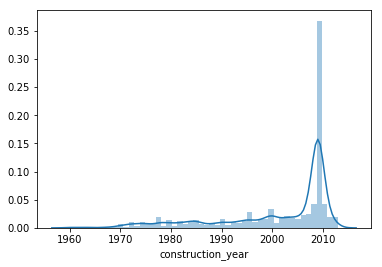

In [209]:
# Strange distribution. It might be due to np.random.choice()?
sns.distplot(X_train['construction_year']);

# Baseline Model Score 2: After Data Cleaning

In [172]:
clf_enc = DecisionTreeClassifier(random_state=42)

clf_enc.fit(X_train, y_train)
clf_enc.score(X_test, y_test)

0.6691077441077441

In [173]:
test_features_wrangled = wrangle(test_features)
y_pred = clf_enc.predict(test_features_wrangled)

sample_submission = pd.read_csv('~/data/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('joseph_wagner_entry_2.csv', index=False)

Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed


# Hyperparameter Search for XGBoost Classifier

In [174]:
search_space = {'max_depth': [4,5,6,7,8,10],
                'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                'n_estimators': [100,110,125,135,150,175,200,250],
                'gamma': [0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.5, 3, 4, 5],
                'min_child_weight': [1,2,3,4,5],
}

opt = RandomizedSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, n_jobs=-1, verbose=3),
    param_distributions=search_space,
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  3.3min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None, num_class=3,
                                           objective='multi:softmax',
                                           random_state=42, reg_alpha=0,
                                           reg_la...
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3, 0.5, 0.6,
                                                  0.8, 1.0, 1.3, 1.7, 2.0, 2.5,
          

In [175]:
best = opt.best_estimator_

In [176]:
pd.Series(best.feature_importances_, X_train.columns).sort_values(ascending=False)

longitude            0.148314
gps_height           0.146280
ward                 0.120086
population           0.090782
installer            0.078503
construction_year    0.064070
lga                  0.051033
extraction_type      0.035683
quantity             0.028786
waterpoint_type      0.027908
source               0.026952
payment_type         0.025476
amount_tsh           0.024201
district_code        0.024121
region_code          0.022327
basin                0.019416
scheme_management    0.018659
management_group     0.010286
permit               0.009728
water_quality        0.008891
source_class         0.006897
quality_group        0.005422
public_meeting       0.004625
latitude             0.001555
gps_height_binned    0.000000
dtype: float32

# XGBoost Score 1

In [177]:
y_pred = best.predict(test_features_wrangled)

sample_submission = pd.read_csv('~/data/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('joseph_wagner_entry_3.csv', index=False)

best.score(X_test, y_test)

0.7694444444444445

# `featuretools` Feature Engineering

In [178]:
X_id = wrangle(features_df, keep_id=True)
X_id.head()

Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed


id  amount_tsh  gps_height  installer  longitude  latitude  basin  \
0  69572      6000.0        1390       1518      34.94     34.94      1   
1   8776         0.0        1399        545      34.70     34.70      4   
2  34310        25.0         686       2048      37.46     37.46      5   
3  67743         0.0         263       1852      38.49     38.49      7   
4  19728         0.0           0        119      31.13     31.13      4   

   region_code  district_code  lga  ward  population  public_meeting  \
0           11              5   51  1426         109               1   
1           20              2  103  1576         280               1   
2           21              4  108  1624         250               1   
3           90             63   87  1571          58               1   
4           18              1   26  1687           1               1   

   scheme_management  permit  construction_year  extraction_type  \
0                  7       0               1999                3   
1                  2       1               2010                3   
2                  7       1               2009                3   
3                  7       1               1986               14   
4                  7       1               2007                3   

   management_group  payment_type  water_quality  quality_group  quantity  \
0                 4             0              6              2         1   
1                 4             2              6              2         2   
2                 4             5              6              2         1   
3                 4             2              6              2         0   
4                 1             2              6              2         3   

   source  source_class  waterpoint_type  gps_height_binned  
0       8             0                1                257  
1       5             1                1                259  
2       0             1                2                133  
3       3             0                2                 58  
4       5             1                1                 12

In [179]:
# I chose these features based on best's feature_importance_ values (and 'id' for a relationship to labels)
synthesis_features = ['id','latitude', 'longitude', 'quantity', 'gps_height', 'ward', 'population']

es = ft.EntitySet("water_pump_entity")
es = es.entity_from_dataframe(entity_id="features", 
                              index='id', 
                              dataframe=X_id[synthesis_features])

es = es.entity_from_dataframe(entity_id="labels", 
                              index='id', 
                              dataframe=labels_df)

In [180]:
new_relationship = ft.Relationship(es['labels']['id'], es['features']['id'])
es = es.add_relationship(new_relationship)
es

Entityset: water_pump_entity
  Entities:
    features [Rows: 59400, Columns: 7]
    labels [Rows: 59400, Columns: 2]
  Relationships:
    features.id -> labels.id

In [181]:
# Perform deep feature synthesis
feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity='labels',
    max_depth=3,
    verbose=True,
    n_jobs=-1,
)

print('\nFinished.')

Built 37 features
EntitySet scattered to workers in 13.506 seconds
Elapsed: 01:02 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 10/10 chunks

Finished.


In [182]:
new_X = X_id.join(feature_matrix, on='id')\
                  .drop(columns=['id', 'status_group'])\
                  .dropna(how='all', axis='columns')
new_X.head()

amount_tsh  gps_height  installer  longitude  latitude  basin  region_code  \
0      6000.0        1390       1518      34.94     34.94      1           11   
1         0.0        1399        545      34.70     34.70      4           20   
2        25.0         686       2048      37.46     37.46      5           21   
3         0.0         263       1852      38.49     38.49      7           90   
4         0.0           0        119      31.13     31.13      4           18   

   district_code  lga  ward  population  public_meeting  scheme_management  \
0              5   51  1426         109               1                  7   
1              2  103  1576         280               1                  2   
2              4  108  1624         250               1                  7   
3             63   87  1571          58               1                  7   
4              1   26  1687           1               1                  7   

   permit  construction_year  extraction_type  management_group  payment_type  \
0       0               1999                3                 4             0   
1       1               2010                3                 4             2   
2       1               2009                3                 4             5   
3       1               1986               14                 4             2   
4       1               2007                3                 1             2   

   water_quality  quality_group  quantity  source  source_class  \
0              6              2         1       8             0   
1              6              2         2       5             1   
2              6              2         1       0             1   
3              6              2         0       3             0   
4              6              2         3       5             1   

   waterpoint_type  gps_height_binned  SUM(features.latitude)  \
0                1                257                   34.94   
1                1                259                   34.70   
2                2                133                   37.46   
3                2                 58                   38.49   
4                1                 12                   31.13   

   SUM(features.longitude)  SUM(features.quantity)  SUM(features.gps_height)  \
0                    34.94                       1                      1390   
1                    34.70                       2                      1399   
2                    37.46                       1                       686   
3                    38.49                       0                       263   
4                    31.13                       3                         0   

   SUM(features.ward)  SUM(features.population)  MAX(features.latitude)  \
0                1426                       109                   34.94   
1                1576                       280                   34.70   
2                1624                       250                   37.46   
3                1571                        58                   38.49   
4                1687                         1                   31.13   

   MAX(features.longitude)  MAX(features.quantity)  MAX(features.gps_height)  \
0                    34.94                       1                      1390   
1                    34.70                       2                      1399   
2                    37.46                       1                       686   
3                    38.49                       0                       263   
4                    31.13                       3                         0   

   MAX(features.ward)  MAX(features.population)  MIN(features.latitude)  \
0                1426                       109                   34.94   
1                1576                       280                   34.70   
2                1624                       250                   37.46   
3                1571                        58      

In [183]:
# Train/Test split new_X 
X_train, X_test, y_train, y_test = train_test_split(new_X, labels_df['status_group'], test_size=0.3, random_state=42)

# Let's get an accuracy score in the notebook as well.
best.fit(X_train, y_train)
best.score(X_test, y_test)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\distributed\utils.py", line 713, in log_errors
    yield
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\distributed\client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\tornado\gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\tornado\concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\tornado\concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "D:\Miniconda\envs\jupyterlab\lib\site-packages\tornado\concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.Cancel

0.803030303030303

# `featuretools` Diagnostics

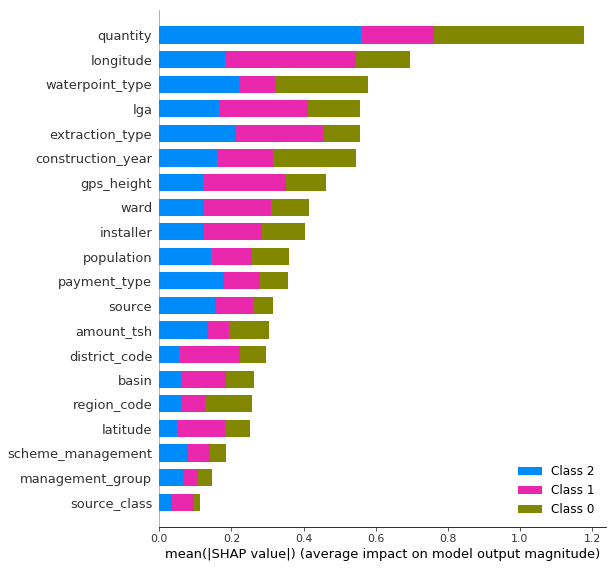

In [184]:
# Plot Shapley values for the top features.
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_test, y_test)
shap.summary_plot(shap_values, X_test);

In [185]:
# Calculate feature importances for new feature set. Did they help?
pd.Series(best.feature_importances_, X_train.columns).sort_values(ascending=False)

gps_height                   0.144067
longitude                    0.143900
ward                         0.121120
population                   0.090871
installer                    0.081108
construction_year            0.062750
lga                          0.051610
extraction_type              0.036006
quantity                     0.028079
source                       0.026869
amount_tsh                   0.026827
waterpoint_type              0.026535
payment_type                 0.024449
district_code                0.023448
region_code                  0.020861
scheme_management            0.019568
basin                        0.018107
management_group             0.010472
latitude                     0.009846
water_quality                0.008470
permit                       0.008386
source_class                 0.006676
quality_group                0.005257
public_meeting               0.004715
MEAN(features.population)    0.000000
MEAN(features.ward)          0.000000
SUM(features

# Outcome: `featuretools` didn't help. 

Below are some visualizations and EDA. **WIP**

In [186]:
# Reset X_train, y_train, ...
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df['status_group'], test_size=0.2, random_state=42)
X_train = wrangle(X_train)
X_test = wrangle(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed
Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed


((47520, 25), (11880, 25), (47520,), (11880,))

In [196]:
features_df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
300      1476
100      1146
50       1139
500      1009
350       986
120       916
400       775
60        706
30        626
40        552
80        533
450       499
20        462
600       438
230       388
75        289
1000      278
800       269
90        265
130       264
25        255
320       249
35        245
360       222
140       215
        ...  
8848        1
628         1
4520        1
468         1
693         1
725         1
789         1
821         1
5300        1
3127        1
2345        1
3031        1
886         1
392         1
424         1
2807        1
726         1
694         1
2569        1
4788        1
662         1
4660        1
406         1
1032        1
1160        1
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [195]:
# I'm not sure why so many np.random.choice() results were 600. 
# There were 21381 0's, and 438 600's.
X_train['population'].value_counts()

600     17403
1        5655
200      1553
150      1512
250      1364
300      1173
100       940
50        924
500       825
350       778
120       735
400       608
60        575
30        494
80        430
40        427
450       395
20        354
230       300
75        237
130       222
800       213
1000      212
90        208
25        206
35        195
320       189
140       182
360       177
210       168
        ...  
2992        1
2248        1
201         1
721         1
593         1
561         1
4523        1
489         1
5200        1
3411        1
2130        1
339         1
3014        1
1555        1
1863        1
1523        1
1363        1
1203        1
104         1
3250        1
819         1
723         1
6800        1
595         1
2345        1
499         1
2514        1
392         1
424         1
662         1
Name: population, Length: 970, dtype: int64

In [197]:
print(features_df.shape, labels_df.shape)
merged = features_df.merge(labels_df, on='id')
merged = wrangle(merged)

(59400, 40) (59400, 2)
Quantity imputed
GPS Height binned
Lat/Long data binned
Lat/Long imputed
Population imputed
Construction Year imputed


In [205]:
# This should be entirely non-zero
merged['population'].value_counts()

70      21590
1        7025
200      1940
150      1892
250      1681
300      1476
100      1146
50       1139
500      1009
350       986
120       916
400       775
60        706
30        626
40        552
80        533
450       499
20        462
600       438
230       388
75        289
1000      278
800       269
90        265
130       264
25        255
320       249
35        245
360       222
140       215
        ...  
8848        1
628         1
4520        1
468         1
693         1
725         1
789         1
821         1
5300        1
2345        1
3127        1
3031        1
392         1
424         1
886         1
2807        1
726         1
2569        1
694         1
4788        1
662         1
4660        1
1032        1
1160        1
3241        1
406         1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1048, dtype: int64

In [207]:
# Same issue as above. I think that np.random.choice() is
# selecting the same value for every 0. This must be fixed, 
# because it'll skew the data wildly, rendering the visualizations useless.
features_df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
300      1476
100      1146
50       1139
500      1009
350       986
120       916
400       775
60        706
30        626
40        552
80        533
450       499
20        462
600       438
230       388
75        289
1000      278
800       269
90        265
130       264
25        255
320       249
35        245
360       222
140       215
        ...  
8848        1
628         1
4520        1
468         1
693         1
725         1
789         1
821         1
5300        1
3127        1
2345        1
3031        1
886         1
392         1
424         1
2807        1
726         1
694         1
2569        1
4788        1
662         1
4660        1
406         1
1032        1
1160        1
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

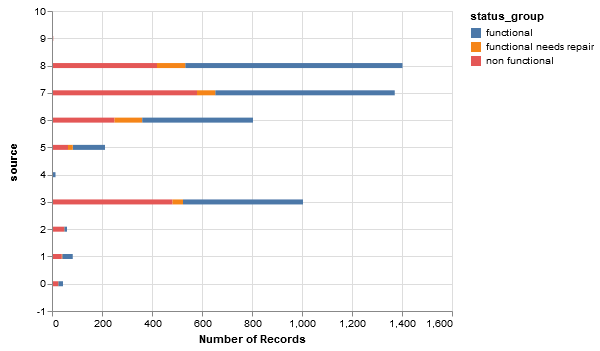

In [198]:
alt.Chart(merged[:4999]).mark_bar().encode(
    x='count(source)',
    y='source',
    color='status_group',
)

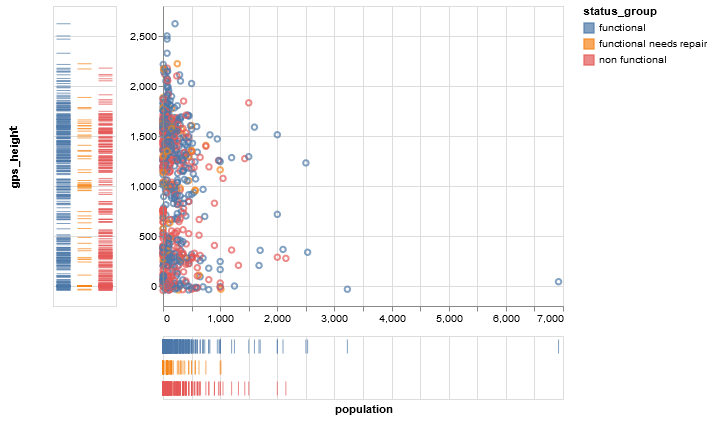

In [201]:
# This is from Altair's examples section, modified for this dataset.
# Configure the options common to all layers
brush = alt.selection(type='interval')
base = alt.Chart(merged[:1000]).add_selection(brush)

# Configure the points
points = base.mark_point().encode(
    x=alt.X('population', title=''),
    y=alt.Y('gps_height', title=''),
    color=alt.condition(brush, 'status_group', alt.value('grey'))
)

# Configure the ticks
tick_axis = alt.Axis(labels=False, domain=False, ticks=False)

x_ticks = base.mark_tick().encode(
    alt.X('population', axis=tick_axis),
    alt.Y('status_group', title='', axis=tick_axis),
    color=alt.condition(brush, 'status_group', alt.value('lightgrey'))
)

y_ticks = base.mark_tick().encode(
    alt.X('status_group', title='', axis=tick_axis),
    alt.Y('gps_height', axis=tick_axis),
    color=alt.condition(brush, 'status_group', alt.value('lightgrey'))
)

# Build the chart
y_ticks | (points & x_ticks)

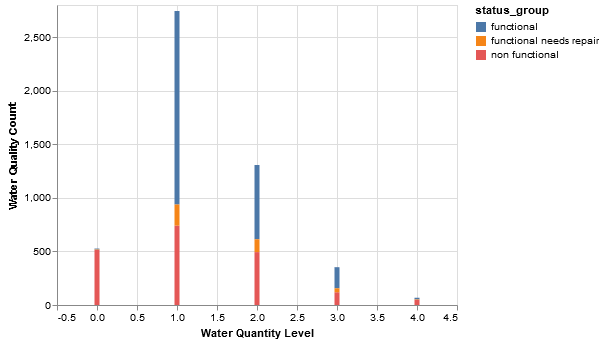

In [208]:
# This is a clear example of the np.choice.random() issue.

alt.Chart(merged[:4999]).mark_bar().encode(
    alt.X('quantity', title='Water Quantity Level'),
    alt.Y('count(quantity)', title='Water Quality Count'),
    color='status_group',
)